# COVID-19 Chest X-Ray Detection

#### Import the required libraries

In [69]:
import os
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import keras
from keras import optimizers, callbacks
from keras.layers import Flatten, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import Xception
from keras.optimizers import Adam
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import warnings
warnings.filterwarnings("ignore")

#### Load the dataset

In [86]:
disease_types=['COVID', 'non-COVID']
data_dir = r"C:\Users\krish\OneDrive\Desktop\Projects\COVID-19 Detection\Dataset"
train_dir = os.path.join(data_dir)

#### Spliting the data into train and test sets

In [87]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [88]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [89]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:11, 210.36it/s]

(2481, 64, 64, 3)


In [90]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

#### Define Xception model architecture

In [92]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [93]:
def build_Xception():
    xception = Xception(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = xception(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(2,activation = 'softmax', name='root')(x)

    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

#### Training the model 

In [94]:
model = build_Xception()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('Xception_Model.keras', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                             horizontal_flip=True, vertical_flip=True) 

datagen.fit(X_train)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 3)           │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2, 2, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,395,838 (81.62 MB)

 Trainable params: 21,336,702 (81.39 MB)

 Non-trainable params: 59,136 (231.00 KB)

In [11]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                    epochs=EPOCHS, verbose=1, callbacks=[annealer, checkpoint], validation_data=(X_val, Y_val))

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5020 - loss: 1.2978
Epoch 1: val_loss improved from inf to 0.69840, saving model to Xception_Model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - accuracy: 0.5024 - loss: 1.2945 - val_accuracy: 0.4728 - val_loss: 0.6984 - learning_rate: 0.0030
Epoch 2/100

Epoch 2: val_loss did not improve from 0.69840
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4728 - val_loss: 0.6984 - learning_rate: 0.0030
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5228 - loss: 1.0699
Epoch 3: val_loss did not improve from 0.69840
31/31 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.5226 - loss: 1.0690 - val_accuracy: 0.4809 - val_loss: 0.7036 - learning_rate: 0.0030
Epoch 4/100

Epoch 4: val_loss did not improve from 0.69840
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4809 - val_loss: 0.7036 - learning_rate: 0.0030
Ep

Epoch 28/100

Epoch 28: val_loss did not improve from 0.57765
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6519 - val_loss: 0.6059 - learning_rate: 0.0030
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7371 - loss: 0.5216
Epoch 29: val_loss did not improve from 0.57765
31/31 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.7367 - loss: 0.5219 - val_accuracy: 0.6539 - val_loss: 0.6065 - learning_rate: 0.0030
Epoch 30/100

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.002100000018253922.

Epoch 30: val_loss did not improve from 0.57765
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6539 - val_loss: 0.6065 - learning_rate: 0.0030
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7128 - loss: 0.5432
Epoch 31: val_loss improved from 0.57765 to 0.54961, saving model to Xception_Model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 206s 7s/step - accuracy: 0

Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8595 - loss: 0.3533
Epoch 55: val_loss improved from 0.33546 to 0.32730, saving model to Xception_Model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 208s 7s/step - accuracy: 0.8596 - loss: 0.3531 - val_accuracy: 0.8753 - val_loss: 0.3273 - learning_rate: 0.0021
Epoch 56/100

Epoch 56: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8753 - val_loss: 0.3273 - learning_rate: 0.0021
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8650 - loss: 0.3273
Epoch 57: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.8645 - loss: 0.3284 - val_accuracy: 0.8732 - val_loss: 0.3280 - learning_rate: 0.0021
Epoch 58/100

Epoch 58: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8732 - val_loss: 0.3280 - learning_ra

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8848 - loss: 0.3098
Epoch 81: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.8848 - loss: 0.3097 - val_accuracy: 0.8612 - val_loss: 0.3431 - learning_rate: 3.5295e-04
Epoch 82/100

Epoch 82: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8612 - val_loss: 0.3431 - learning_rate: 3.5295e-04
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8732 - loss: 0.3263
Epoch 83: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.8733 - loss: 0.3261 - val_accuracy: 0.8612 - val_loss: 0.3370 - learning_rate: 3.5295e-04
Epoch 84/100

Epoch 84: val_loss did not improve from 0.32730
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8612 - val_loss: 0.3370 - learning_rate: 3.5295e-04
Epoch 85/100
31/31 ━━━━━━━━━━

#### Visualizing training accuracy and loss over epochs

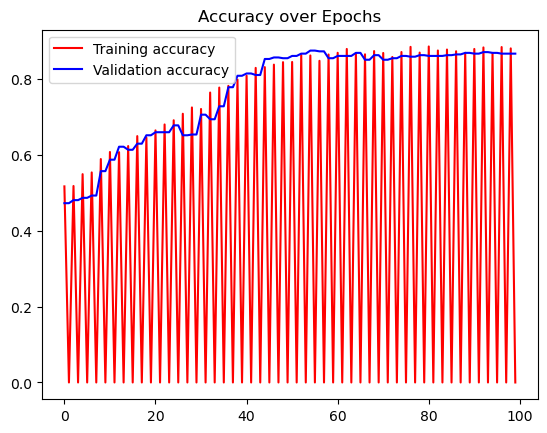

<Figure size 640x480 with 0 Axes>

In [119]:
epochs = range(len(acc))
plt.plot(epochs, history.history['accuracy'], color='red', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='blue', label='Validation accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

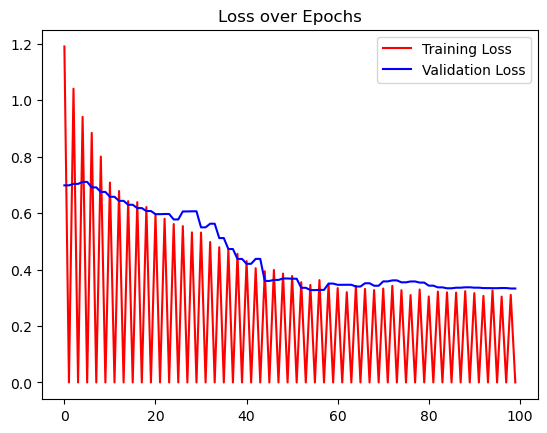

<Figure size 640x480 with 0 Axes>

In [120]:
epochs = range(len(acc))
plt.plot(epochs, history.history['loss'], color='red', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='blue', label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [99]:
model.load_weights("Xception_Model.keras")
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.8693 - loss: 0.3299
Test Loss: 0.3273008465766907
Test accuracy: 0.8752515316009521


#### Evaluating the model on the test dataset and providing the accuracy, precision, recall and F1-score

In [100]:
Y_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)
accuracy = accuracy_score(Y_test_labels, Y_pred)

print(f'The accuracy of the model is: {accuracy:.4f}')
print(classification_report(Y_test_labels, Y_pred, target_names=['COVID', 'non-COVID']))

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step
The accuracy of the model is: 0.8753
              precision    recall  f1-score   support

       COVID       0.90      0.83      0.87       239
   non-COVID       0.86      0.91      0.88       258

    accuracy                           0.88       497
   macro avg       0.88      0.87      0.87       497
weighted avg       0.88      0.88      0.87       497



#### Generate a confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step


Text(0.5, 1.0, 'Confusion Matrix')

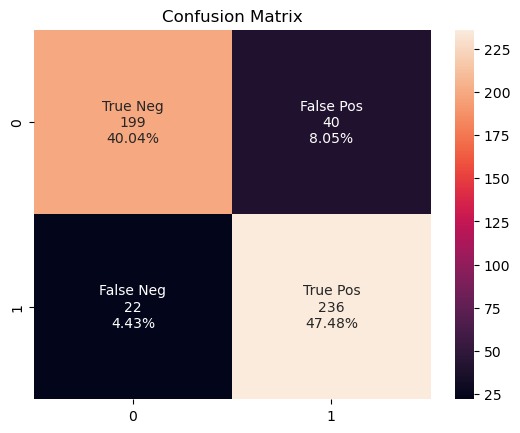

In [102]:
Y_pred = model.predict(X_test)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_testx = np.argmax(Y_test, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")

#### Predict if the image has COVID-19 presence or not

In [113]:
def predict_image(image_path, model, target_size=(64, 64), display_size=(256, 256)):

    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)

    disease_types = ['COVID', 'non-COVID']
    predicted_disease = disease_types[predicted_class[0]]
    confidence = np.max(prediction)

    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    img_resized = cv2.resize(img_original, display_size, interpolation=cv2.INTER_LINEAR)

    plt.imshow(img_resized)
    plt.title(f"Predicted Disease: {predicted_disease}\nConfidence: {confidence:.4f}")
    plt.axis('off')  
    plt.show()

    return predicted_disease, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


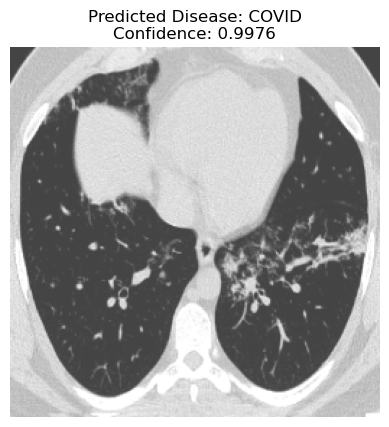

In [114]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\COVID-19 Detection\Dataset\COVID\Covid (64).png"
disease, confidence = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


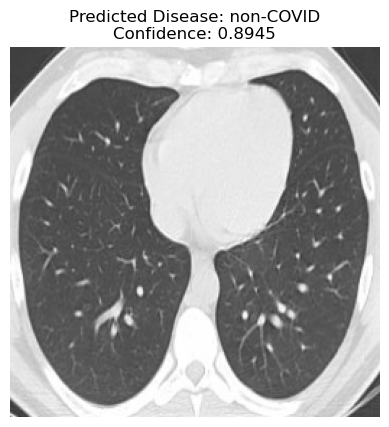

In [115]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\COVID-19 Detection\Dataset\non-COVID\Non-Covid (36).png"
disease, confidence = predict_image(image_path, model)